In [1]:
import numpy as np
from scipy.spatial import Delaunay

constraints = []
constraints.append(np.array([[20, 50], [20, 150], [40, 150], [40, 50]]))
constraints.append(np.array([[10, 10], [10, 30], [40, 30], [40, 10]]))
yv, xv = np.meshgrid(range(0, 200), range(0, 200))
og = np.zeros_like(xv)

for constraint in constraints:
    hull = Delaunay(constraint)
    ogInner = np.zeros_like(xv)
    len, wid = xv.shape
    for i in range(len):
        for j in range(wid):
            ogInner[i, j] = hull.find_simplex([xv[i,j],yv[i,j]])


    og[ogInner != -1] = 1


In [2]:
from rrtplanner import RRTStar, random_point_og
n = 1200
r_rewire = 80
rrts = RRTStar(og, n, r_rewire)
xstart = np.array([0., 100.])
xgoal = np.array([100., 100.])
T, gv = rrts.plan(xstart, xgoal)

100%|██████████| 1200/1200 [00:01<00:00, 1016.82it/s]


In [3]:
path = rrts.route2gv(T, gv)
path_pts = rrts.vertices_as_ndarray(T, path)

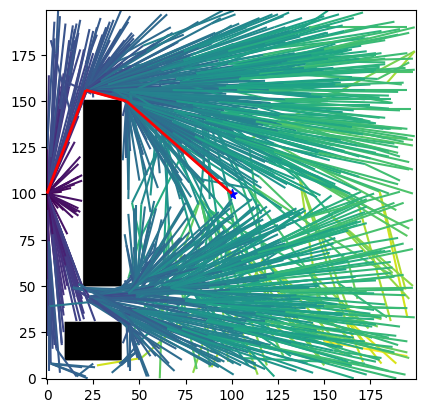

In [4]:
from rrtplanner import plot_rrt_lines, plot_path, plot_og, plot_start_goal
import matplotlib.pyplot as plt

# create figure and ax.
fig = plt.figure()
ax = fig.add_subplot()

# these functions alter ax in-place.
plot_og(ax, og)
plot_start_goal(ax, xstart, xgoal)
plot_rrt_lines(ax, T)
plot_path(ax, path_pts)

plt.show()

In [5]:
timeHor = 100
from supportFunctions import *

print(pathlens(path_pts))


[59.80802622 22.8035085  75.82216035]


In [6]:
tEnd = 20
pathLengths = pathlens(path_pts)
vel = sum(pathLengths)/tEnd
distanceOfPoints = np.linspace(start = 0, stop = sum(pathLengths), num = tEnd)
referencePoints = []
index = 0
for i in range(distanceOfPoints.size):
    while(distanceOfPoints[i] > pathLengths[index]):
        distanceOfPoints = distanceOfPoints - pathLengths[index]
        index = index + 1
    multiplier = distanceOfPoints[i]/pathLengths[index]
    referencePoints.append(path_pts[index, 0, :] *(1-multiplier) + path_pts[index, 1, :]*multiplier)

print(referencePoints)

[array([  0., 100.]), array([  2.92788338, 107.80768902]), array([  5.85576677, 115.61537804]), array([  8.78365015, 123.42306706]), array([ 11.71153353, 131.23075608]), array([ 14.63941691, 139.03844511]), array([ 17.5673003 , 146.84613413]), array([ 20.49518368, 154.65382315]), array([ 27.65773675, 154.18425361]), array([ 35.70253133, 151.99021873]), array([ 43.58232808, 149.48918589]), array([ 49.85095829, 143.99038746]), array([ 56.11958851, 138.49158903]), array([ 62.38821872, 132.9927906 ]), array([ 68.65684893, 127.49399216]), array([ 74.92547915, 121.99519373]), array([ 81.19410936, 116.4963953 ]), array([ 87.46273957, 110.99759687]), array([ 93.73136979, 105.49879843]), array([100., 100.])]


In [7]:
def calculateReferencePoints(timeEnd, path_points):
    pathLengths = pathlens(path_points)
    vel = sum(pathLengths)/timeEnd
    distanceOfPoints = np.linspace(start = 0, stop = sum(pathLengths), num = timeEnd)
    referencePoints = []
    referencePoints.append(path_points[0, 0, :])
    referenceVels = []
    index = 0
    for i in range(1, distanceOfPoints.size):
        while(distanceOfPoints[i] > pathLengths[index]):
            distanceOfPoints = distanceOfPoints - pathLengths[index]
            index = index + 1
        multiplier = distanceOfPoints[i]/pathLengths[index]
        referencePoints.append(path_points[index, 0, :] *(1-multiplier) + path_points[index, 1, :]*multiplier)
        referenceVels.append(referencePoints[i]- referencePoints[i-1])
    referenceVels.append((referencePoints[0]- referencePoints[1]) * 0)

    return referencePoints, referenceVels

Xref = np.zeros([tEnd, 4])
referencePoints, referenceVels= calculateReferencePoints(20, path_pts)
Xref[:, 0:2] = referencePoints
Xref[:, 2:4] = referenceVels
print(Xref)

[[  0.         100.           2.92788338   7.80768902]
 [  2.92788338 107.80768902   2.92788338   7.80768902]
 [  5.85576677 115.61537804   2.92788338   7.80768902]
 [  8.78365015 123.42306706   2.92788338   7.80768902]
 [ 11.71153353 131.23075608   2.92788338   7.80768902]
 [ 14.63941691 139.03844511   2.92788338   7.80768902]
 [ 17.5673003  146.84613413   2.92788338   7.80768902]
 [ 20.49518368 154.65382315   7.16255307  -0.46956953]
 [ 27.65773675 154.18425361   8.04479458  -2.19403489]
 [ 35.70253133 151.99021873   7.87979675  -2.50103283]
 [ 43.58232808 149.48918589   6.26863021  -5.49879843]
 [ 49.85095829 143.99038746   6.26863021  -5.49879843]
 [ 56.11958851 138.49158903   6.26863021  -5.49879843]
 [ 62.38821872 132.9927906    6.26863021  -5.49879843]
 [ 68.65684893 127.49399216   6.26863021  -5.49879843]
 [ 74.92547915 121.99519373   6.26863021  -5.49879843]
 [ 81.19410936 116.4963953    6.26863021  -5.49879843]
 [ 87.46273957 110.99759687   6.26863021  -5.49879843]
 [ 93.7313

In [19]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate data.
m = 20
n = 15
np.random.seed(10)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Define and solve the CVXPY problem.
x = cp.Variable(n)
cost = cp.sum_squares(A @ x - b)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("The optimal x is")
print(x.value)
print("The norm of the residual is ", cp.norm(A @ x - b, p=2).value)


The optimal value is 6.986654208206443
The optimal x is
[-0.11656121 -1.20538395  0.41542089  0.15348722 -0.46602653  0.28003071
 -1.98062115 -0.23437698  0.35102302 -0.72744782 -0.89190075  0.92563981
 -2.00027239  0.23955163  0.18434091]
The norm of the residual is  2.64322799020562


In [135]:
A = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0,0,0,1]])
B = np.array([[0, 0], [0, 0], [1,0], [0, 1]])
np.hstack([A, B])

array([[1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1]])